# How exposure to social media and advertising affected use of e-cigarettes among youth during the pandemic?


Covariates: Age (QN1), gender (QN2), grade (QN3), race (QN5), ethnicity (QN4A-E), cigarettes use (QN38), how often see ads or promotions on internet, newspaper/magazines, stores, TV (QN128-QN131), Social Media (QN134), how often use social media (QN133), who you get from

Outcomes variable: current e-cigarettes use (how many days in the past 30 days) (QN9), Have you ever used an e-cigarette(QN6)

Method: Multinomial logistic regression

Predictors: QN128-QN138: internet, newspaper, stores, social media (what site, interaction, who)


In [1]:
!pip install scikit-plot
!pip install mord 

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# for regressions with statsmodels:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

# for regressions with scikit-learn:
import sklearn.linear_model as sklm
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, \
                            accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#for plotting confusion matrix:
import scikitplot as skplt

#for ordinal logistic regression
from mord import LogisticIT

#for KNN
# for KNN:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

In [3]:
#These are utility tools of the DMBA book. 
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import classificationSummary, gainsChart, liftChart

In [4]:
# visualization and tuning the aesthetics
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 
plt.rc('font', size = 12) 
plt.rc('figure', figsize = (6, 5))

In [5]:
nyts = pd.read_excel('nyts2021.xlsx', na_values= ' ', usecols=['QN1','QN2','QN3','QN4A','QN4B','QN4C','QN4D','QN4E','QN5A','QN5B','QN5C','QN5D','QN5E','QN6',
                                                               'QN20AA','QN20AB','QN20AC','QN20AD','QN20AE','QN20AF','QN20AG','QN20AH',
                                                               'QN35','QN38','QN9','QN128','QN129','QN130','QN131','QN133','QN134',
                                                               'QN135A','QN135B','QN135C','QN135D','QN135E','QN135F','QN135G','QN135H',
                                                              'psu','stratum','hsms','finwgt','v_stratum'])

In [6]:
nyts

,QN1,QN2,QN3,QN4A,QN4B,QN4C,QN4D,QN4E,QN5A,QN5B,...,QN135D,QN135E,QN135F,QN135G,QN135H,psu,stratum,hsms,finwgt,v_stratum
0,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16452,BR3,MS,262.047226,103
1,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,NaN,1.0,1.0,NaN,16452,BR3,MS,345.984971,103
2,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16452,BR3,MS,262.047226,103
3,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,16452,BR3,MS,369.050636,103
4,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16452,BR3,MS,262.047226,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20408,9.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,786771,HR1,HS,546.786234,201
20409,10.0,2.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,786771,HR1,HS,651.521383,201
20410,NaN,1.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,786771,HR1,HS,546.786234,201
20411,10.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,786771,HR1,HS,546.786234,201


In [7]:
nyts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20413 entries, 0 to 20412
Data columns (total 44 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   QN1        20344 non-null  float64
 1   QN2        20287 non-null  float64
 2   QN3        20326 non-null  float64
 3   QN4A       14852 non-null  float64
 4   QN4B       2988 non-null   float64
 5   QN4C       481 non-null    float64
 6   QN4D       143 non-null    float64
 7   QN4E       1863 non-null   float64
 8   QN5A       1391 non-null   float64
 9   QN5B       1433 non-null   float64
 10  QN5C       4641 non-null   float64
 11  QN5D       521 non-null    float64
 12  QN5E       12702 non-null  float64
 13  QN6        20212 non-null  float64
 14  QN9        3590 non-null   float64
 15  QN20AA     377 non-null    float64
 16  QN20AB     399 non-null    float64
 17  QN20AC     230 non-null    float64
 18  QN20AD     292 non-null    float64
 19  QN20AE     426 non-null    float64
 20  QN20AF

In [8]:
nyts.columns

Index(['QN1', 'QN2', 'QN3', 'QN4A', 'QN4B', 'QN4C', 'QN4D', 'QN4E', 'QN5A',
       'QN5B', 'QN5C', 'QN5D', 'QN5E', 'QN6', 'QN9', 'QN20AA', 'QN20AB',
       'QN20AC', 'QN20AD', 'QN20AE', 'QN20AF', 'QN20AG', 'QN20AH', 'QN35',
       'QN38', 'QN128', 'QN129', 'QN130', 'QN131', 'QN133', 'QN134', 'QN135A',
       'QN135B', 'QN135C', 'QN135D', 'QN135E', 'QN135F', 'QN135G', 'QN135H',
       'psu', 'stratum', 'hsms', 'finwgt', 'v_stratum'],
      dtype='object')

In [9]:
nyts.rename(columns = {'QN1':'Age', 'QN2':'Gender', 'QN3':'Grade',
                       'QN4A':'Not_Hispanic', 'QN4B':'Yes_Mexican', 'QN4C':'Yes_Puerto','QN4D':'Yes_Cuban','QN4E':'Yes_Another',
                       'QN9': 'E_cigarettes_use','QN6':'Ever_e_cigarettes_use',
                       'QN20AA':'Myself','QN20AB':'Had_someone_buy','QN20AC':'Ask_someone_give','QN20AD':'Someone_offered','QN20AE':'Friend','QN20AF':'Family_member','QN20AG':'Store_people','QN20AH':'Other',
                       'QN35':'Ever_cigarettes_use', 'QN38':'Current_cigarettes_use', 
                       'QN128':'Internet', 'QN129': 'Newspaper', 'QN130':'Store', 'QN131': 'TV', 'QN133':'Social_media_use','QN134':'Social_media_freq', 
                       'QN135A': 'Facebook', 'QN135B':'Instgram', 'QN135C':'Snapchat','QN135D':'Tiktok', 'QN135E':'Twitter', 'QN135F':'Raddit', 'QN135G':'Youtube', 'QN135H':'Other site'}, 
            inplace = True)

In [10]:
nyts

,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,QN5A,QN5B,...,Tiktok,Twitter,Raddit,Youtube,Other site,psu,stratum,hsms,finwgt,v_stratum
0,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16452,BR3,MS,262.047226,103
1,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,NaN,1.0,1.0,NaN,16452,BR3,MS,345.984971,103
2,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16452,BR3,MS,262.047226,103
3,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,16452,BR3,MS,369.050636,103
4,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16452,BR3,MS,262.047226,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20408,9.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,786771,HR1,HS,546.786234,201
20409,10.0,2.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,786771,HR1,HS,651.521383,201
20410,NaN,1.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,786771,HR1,HS,546.786234,201
20411,10.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,786771,HR1,HS,546.786234,201


In [11]:
nyts.describe()

,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,QN5A,QN5B,...,Instgram,Snapchat,Tiktok,Twitter,Raddit,Youtube,Other site,psu,finwgt,v_stratum
count,20344.000000,20287.000000,20326.000000,14852.0,2988.0,481.0,143.0,1863.0,1391.0,1433.0,...,7194.0,6802.0,7454.0,2261.0,1222.0,6846.0,938.0,20413.000000,20413.000000,20413.000000
mean,6.351701,1.488934,3.757158,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,380496.026454,1350.306520,156.532210
std,2.061753,0.499890,1.975811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227281.648235,1221.476689,50.541837
min,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16452.000000,7.287500,101.000000
25%,5.000000,1.000000,2.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,187711.000000,489.336330,104.000000
50%,6.000000,1.000000,4.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,373837.000000,924.124448,113.000000
75%,8.000000,2.000000,5.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,559424.000000,1817.321946,204.000000
max,11.000000,2.000000,8.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,786771.000000,4909.239529,214.000000


In [12]:
nyts.isna().sum()

Age                          69
Gender                      126
Grade                        87
Not_Hispanic               5561
Yes_Mexican               17425
Yes_Puerto                19932
Yes_Cuban                 20270
Yes_Another               18550
QN5A                      19022
QN5B                      18980
QN5C                      15772
QN5D                      19892
QN5E                       7711
Ever_e_cigarettes_use       201
E_cigarettes_use          16823
Myself                    20036
Had_someone_buy           20014
Ask_someone_give          20183
Someone_offered           20121
Friend                    19987
Family_member             20257
Store_people              20361
Other                     20173
Ever_cigarettes_use         458
Current_cigarettes_use    18868
Internet                   1667
Newspaper                  1769
Store                      1826
TV                         1859
Social_media_use           1787
Social_media_freq          3594
Facebook

In [13]:
nyts['QN5A'].fillna(0, inplace=True)
nyts['QN5B'].fillna(0, inplace=True)
nyts['QN5C'].fillna(0, inplace=True)
nyts['QN5D'].fillna(0, inplace=True)
nyts['QN5E'].fillna(0, inplace=True)
conditions = [(nyts['QN5A'] == 1) & (nyts['QN5B'] != 1) & (nyts['QN5C'] != 1) & (nyts['QN5D'] != 1) & (nyts['QN5E'] != 1), (nyts['QN5B'] == 1) & (nyts['QN5A'] != 1) & (nyts['QN5C'] != 1) & (nyts['QN5D'] != 1) & (nyts['QN5E'] != 1), (nyts['QN5C'] == 1)& (nyts['QN5A'] != 1) & (nyts['QN5B'] != 1) & (nyts['QN5D'] != 1) & (nyts['QN5E'] != 1), (nyts['QN5D'] == 1)& (nyts['QN5A'] != 1) & (nyts['QN5C'] != 1) & (nyts['QN5B'] != 1) & (nyts['QN5E'] != 1), (nyts['QN5E'] == 1)& (nyts['QN5A'] != 1) & (nyts['QN5C'] != 1) & (nyts['QN5D'] != 1) & (nyts['QN5B'] != 1), nyts['QN5A'] + nyts['QN5B']+ nyts['QN5C']+ nyts['QN5D'] + nyts['QN5E'] > 1]
outputs = ['American Indian or Alaska Native', 'Asian', 'Black or African American', 'Native Hawaiian or Other Pacific Islander', 'White', 'Multi-racial']
nyts['Race'] = np.select(conditions, outputs, 'Missing')
nyts.head(20)

,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,QN5A,QN5B,...,Twitter,Raddit,Youtube,Other site,psu,stratum,hsms,finwgt,v_stratum,Race
0,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,16452,BR3,MS,262.047226,103,White
1,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,NaN,1.0,1.0,NaN,16452,BR3,MS,345.984971,103,Multi-racial
2,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,16452,BR3,MS,262.047226,103,White
3,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,1.0,NaN,16452,BR3,MS,369.050636,103,White
4,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,16452,BR3,MS,262.047226,103,White
5,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,NaN,NaN,1.0,NaN,16452,BR3,MS,345.984971,103,Asian
6,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,16452,BR3,MS,262.047226,103,White
7,3.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,1.0,NaN,1.0,NaN,16452,BR3,MS,254.413054,103,Black or African American
8,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,16452,BR3,MS,369.050636,103,White
9,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,16452,BR3,MS,262.047226,103,White


In [14]:
nyts.rename(columns = {'QN4A':'Not_Hispanic','QN4B':'Yes_Mexican','QN4C':'Yes_Puerto','QN4D': 'Yes_Cuban', 'QN4E':'Yes_Another','QN5A':'American Indian or Alaska Native', 'QN5B':'Asian', 'QN5C':'Black or African American', 'QN5D':'Native Hawaiian or Other Pacific Islander', 'QN5E':'White'}, inplace = True)

# Stats of Ever Cig Use

In [15]:
nyts.Ever_cigarettes_use.describe()

count    19955.000000
mean         1.921924
std          0.268297
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: Ever_cigarettes_use, dtype: float64

In [16]:
nyts.Ever_cigarettes_use.isna().sum()

458

In [17]:
nyts.Ever_cigarettes_use.value_counts()

2.0    18397
1.0     1558
Name: Ever_cigarettes_use, dtype: int64

In [18]:
nyts.Ever_cigarettes_use.value_counts()

2.0    18397
1.0     1558
Name: Ever_cigarettes_use, dtype: int64

In [19]:
nyts.Ever_cigarettes_use.fillna(3, inplace=True)

In [20]:
nyts.Ever_cigarettes_use.value_counts()

2.0    18397
1.0     1558
3.0      458
Name: Ever_cigarettes_use, dtype: int64

# Stats of Ever E-cig Use

In [21]:
nyts.Ever_e_cigarettes_use.describe()

count    20212.000000
mean         1.818672
std          0.385299
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: Ever_e_cigarettes_use, dtype: float64

In [22]:
nyts.Ever_e_cigarettes_use.isna().sum()

201

In [23]:
nyts.Ever_e_cigarettes_use.value_counts()

2.0    16547
1.0     3665
Name: Ever_e_cigarettes_use, dtype: int64

In [24]:
nyts['Ever_e_cigarettes_use']= nyts['Ever_e_cigarettes_use'].replace([2],0)

In [25]:
nyts.Ever_e_cigarettes_use.fillna(2, inplace=True)

In [26]:
nyts.Ever_e_cigarettes_use.value_counts()

0.0    16547
1.0     3665
2.0      201
Name: Ever_e_cigarettes_use, dtype: int64

# Stats of Current E-cig Use

In [27]:
nyts.E_cigarettes_use.describe()

count    3590.000000
mean        5.357660
std         9.931905
min         0.000000
25%         0.000000
50%         0.000000
75%         4.000000
max        30.000000
Name: E_cigarettes_use, dtype: float64

In [28]:
nyts.E_cigarettes_use.isna().sum()

16823

In [29]:
nyts.E_cigarettes_use.value_counts()

0.0     2154
30.0     336
1.0      286
2.0      138
20.0      94
3.0       82
5.0       80
15.0      74
10.0      73
4.0       52
25.0      40
28.0      24
7.0       23
6.0       21
29.0      13
12.0      12
8.0        9
14.0       8
24.0       8
27.0       8
9.0        8
21.0       7
23.0       6
13.0       6
16.0       5
19.0       5
26.0       4
17.0       4
11.0       4
18.0       3
22.0       3
Name: E_cigarettes_use, dtype: int64

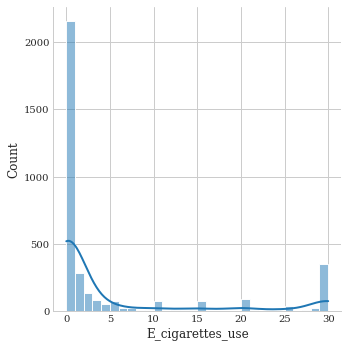

In [30]:
sns.displot(nyts['E_cigarettes_use'], kind='hist', bins=30, kde=True, rug=False)

In [31]:
E_cigarettes_use_filter= nyts[(nyts['E_cigarettes_use']>0) & (nyts['E_cigarettes_use']<31)]
E_cigarettes_use_filter

,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,American Indian or Alaska Native,Asian,...,Twitter,Raddit,Youtube,Other site,psu,stratum,hsms,finwgt,v_stratum,Race
107,6.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,16452,BR3,MS,519.361461,103,White
111,6.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,16452,BR3,MS,548.406224,103,Black or African American
120,6.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,16452,BR3,MS,377.422621,103,Black or African American
206,7.0,1.0,4.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,16452,BR3,HS,473.949945,103,White
221,6.0,2.0,4.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,1.0,NaN,16452,BR3,HS,455.581789,103,Black or African American
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20373,8.0,1.0,5.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,786771,HR1,HS,568.982787,201,White
20376,10.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,786771,HR1,HS,546.786234,201,White
20378,9.0,1.0,6.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,1.0,NaN,786771,HR1,HS,832.520637,201,White
20394,10.0,2.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,1.0,NaN,786771,HR1,HS,651.521383,201,White


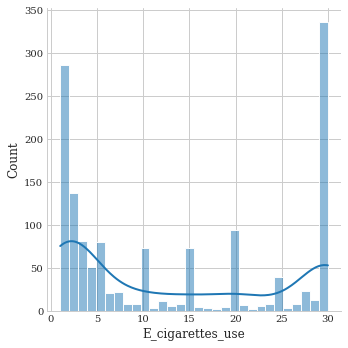

In [32]:
sns.displot(E_cigarettes_use_filter['E_cigarettes_use'], kind='hist', bins=30, kde=True, rug=False)

In [33]:
E_cigarettes_use_filter.E_cigarettes_use.describe()

count    1436.000000
mean       13.394150
std        11.789528
min         1.000000
25%         2.000000
50%        10.000000
75%        28.000000
max        30.000000
Name: E_cigarettes_use, dtype: float64

### Cutpoints testing: 1 cut

Mean: 0, 13.39
Count: 4154, 1436

### Cutpoints testing: 2 cuts

In [34]:
E_cigarettes_days_filter1 = E_cigarettes_use_filter['E_cigarettes_use']
bins = [0.5,15.5,30.5]
bin_names = ['1', '2']
E_cigarettes_use_filter['E_cigarettes_use_category_filter1'] = pd.cut(E_cigarettes_days_filter1,bins,labels=bin_names)
E_cigarettes_use_filter

C:\Users\zhulu\AppData\Local\Temp\ipykernel_9236\1443728554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  E_cigarettes_use_filter['E_cigarettes_use_category_filter1'] = pd.cut(E_cigarettes_days_filter1,bins,labels=bin_names)


,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,American Indian or Alaska Native,Asian,...,Raddit,Youtube,Other site,psu,stratum,hsms,finwgt,v_stratum,Race,E_cigarettes_use_category_filter1
107,6.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,16452,BR3,MS,519.361461,103,White,1
111,6.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,16452,BR3,MS,548.406224,103,Black or African American,2
120,6.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,16452,BR3,MS,377.422621,103,Black or African American,1
206,7.0,1.0,4.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,16452,BR3,HS,473.949945,103,White,2
221,6.0,2.0,4.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,1.0,NaN,16452,BR3,HS,455.581789,103,Black or African American,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20373,8.0,1.0,5.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,786771,HR1,HS,568.982787,201,White,2
20376,10.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,786771,HR1,HS,546.786234,201,White,1
20378,9.0,1.0,6.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,1.0,NaN,786771,HR1,HS,832.520637,201,White,1
20394,10.0,2.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,1.0,NaN,786771,HR1,HS,651.521383,201,White,1


In [35]:
E_cigarettes_use_filter.E_cigarettes_use_category_filter1.value_counts()

1    876
2    560
Name: E_cigarettes_use_category_filter1, dtype: int64

In [36]:
E_cigarettes_use_filter.groupby('E_cigarettes_use_category_filter1')['E_cigarettes_use'].mean()

E_cigarettes_use_category_filter1
1     4.640411
2    27.087500
Name: E_cigarettes_use, dtype: float64

### Cutpoints testing: 3 cuts

In [37]:
E_cigarettes_days_filter2 = E_cigarettes_use_filter['E_cigarettes_use']
bins = [0.5,5.5,25.5,30.5]
bin_names = ['1', '2', '3']
E_cigarettes_use_filter['E_cigarettes_use_category_filter2'] = pd.cut(E_cigarettes_days_filter2,bins,labels=bin_names)
E_cigarettes_use_filter

C:\Users\zhulu\AppData\Local\Temp\ipykernel_9236\748992825.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  E_cigarettes_use_filter['E_cigarettes_use_category_filter2'] = pd.cut(E_cigarettes_days_filter2,bins,labels=bin_names)


,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,American Indian or Alaska Native,Asian,...,Youtube,Other site,psu,stratum,hsms,finwgt,v_stratum,Race,E_cigarettes_use_category_filter1,E_cigarettes_use_category_filter2
107,6.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,16452,BR3,MS,519.361461,103,White,1,1
111,6.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,16452,BR3,MS,548.406224,103,Black or African American,2,3
120,6.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,16452,BR3,MS,377.422621,103,Black or African American,1,1
206,7.0,1.0,4.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,16452,BR3,HS,473.949945,103,White,2,2
221,6.0,2.0,4.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,1.0,NaN,16452,BR3,HS,455.581789,103,Black or African American,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20373,8.0,1.0,5.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,786771,HR1,HS,568.982787,201,White,2,3
20376,10.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,786771,HR1,HS,546.786234,201,White,1,1
20378,9.0,1.0,6.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,1.0,NaN,786771,HR1,HS,832.520637,201,White,1,1
20394,10.0,2.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,1.0,NaN,786771,HR1,HS,651.521383,201,White,1,1


In [38]:
E_cigarettes_use_filter.E_cigarettes_use_category_filter2.value_counts()

1    638
2    413
3    385
Name: E_cigarettes_use_category_filter2, dtype: int64

In [39]:
E_cigarettes_use_filter.groupby('E_cigarettes_use_category_filter2')['E_cigarettes_use'].mean()

E_cigarettes_use_category_filter2
1     2.219436
2    15.421308
3    29.737662
Name: E_cigarettes_use, dtype: float64

In [40]:
conditions_E_cigarettes_use = [nyts['E_cigarettes_use'] >= 1, nyts['E_cigarettes_use'] == 0]
outputs_E_cigarettes_use = ['1', '0']
nyts['E_cigarettes_use_category'] = np.select(conditions_E_cigarettes_use, outputs_E_cigarettes_use, '2')
nyts

,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,American Indian or Alaska Native,Asian,...,Raddit,Youtube,Other site,psu,stratum,hsms,finwgt,v_stratum,Race,E_cigarettes_use_category
0,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,16452,BR3,MS,262.047226,103,White,2
1,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,1.0,1.0,NaN,16452,BR3,MS,345.984971,103,Multi-racial,2
2,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,NaN,NaN,NaN,16452,BR3,MS,262.047226,103,White,2
3,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,1.0,NaN,16452,BR3,MS,369.050636,103,White,2
4,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,16452,BR3,MS,262.047226,103,White,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20408,9.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,786771,HR1,HS,546.786234,201,White,0
20409,10.0,2.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,1.0,NaN,786771,HR1,HS,651.521383,201,White,0
20410,NaN,1.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,786771,HR1,HS,546.786234,201,White,2
20411,10.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,1.0,NaN,786771,HR1,HS,546.786234,201,White,2


In [41]:
nyts['E_cigarettes_use_category'].value_counts()

2    16823
0     2154
1     1436
Name: E_cigarettes_use_category, dtype: int64

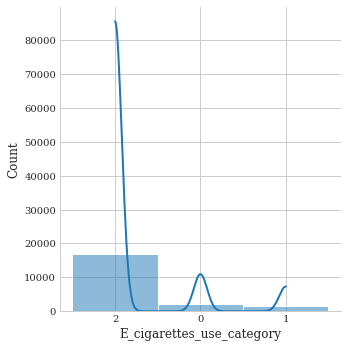

In [42]:
sns.displot(nyts['E_cigarettes_use_category'], kind='hist', bins=10, kde=True, rug=False)

# Stats of Age

In [43]:
nyts.Age.describe()

count    20344.000000
mean         6.351701
std          2.061753
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         11.000000
Name: Age, dtype: float64

In [44]:
nyts.Age.isna().sum()

69

In [45]:
nyts.Age.value_counts()

5.0     3308
4.0     3204
6.0     3079
7.0     2872
8.0     2562
9.0     2504
3.0     1391
10.0    1208
11.0     178
1.0       34
2.0        4
Name: Age, dtype: int64

In [46]:
nyts['Age'].fillna(12, inplace=True)

In [47]:
nyts.Age.value_counts()

5.0     3308
4.0     3204
6.0     3079
7.0     2872
8.0     2562
9.0     2504
3.0     1391
10.0    1208
11.0     178
12.0      69
1.0       34
2.0        4
Name: Age, dtype: int64

In [48]:
nyts.Age.isna().sum()

0

In [49]:
nyts['Age_continuous'] = nyts['Age']+8

In [50]:
Age_filter= nyts[(nyts['Age_continuous']>0) & (nyts['Age_continuous']<20)]
Age_filter

,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,American Indian or Alaska Native,Asian,...,Youtube,Other site,psu,stratum,hsms,finwgt,v_stratum,Race,E_cigarettes_use_category,Age_continuous
0,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,16452,BR3,MS,262.047226,103,White,2,11.0
1,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,1.0,NaN,16452,BR3,MS,345.984971,103,Multi-racial,2,12.0
2,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,NaN,NaN,16452,BR3,MS,262.047226,103,White,2,12.0
3,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,1.0,NaN,16452,BR3,MS,369.050636,103,White,2,12.0
4,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,16452,BR3,MS,262.047226,103,White,2,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20407,10.0,2.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,786771,HR1,HS,651.521383,201,White,2,18.0
20408,9.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,786771,HR1,HS,546.786234,201,White,0,17.0
20409,10.0,2.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,1.0,NaN,786771,HR1,HS,651.521383,201,White,0,18.0
20411,10.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,1.0,NaN,786771,HR1,HS,546.786234,201,White,2,18.0


In [51]:
Age_filter['Age_continuous'].describe()

count    20344.000000
mean        14.351701
std          2.061753
min          9.000000
25%         13.000000
50%         14.000000
75%         16.000000
max         19.000000
Name: Age_continuous, dtype: float64

Age_years = nyts['Age']
bins = [0,3.5,4.5,5.5,6.5,7.5,8.5,9.5,11.5]
bin_names = ['1', '2', '3', '4', '5', '6', '7', '8']
nyts['Age_category'] = pd.cut(Age_years,bins,labels=bin_names)
nyts

In [52]:
AgecountByE_cigarettes_use_category = nyts.groupby('Age')[['E_cigarettes_use_category']].count()
AgecountByE_cigarettes_use_category

,E_cigarettes_use_category
Age,
1.0,34
2.0,4
3.0,1391
4.0,3204
5.0,3308
6.0,3079
7.0,2872
8.0,2562
9.0,2504


In [53]:
pd.crosstab(nyts.Age, nyts.E_cigarettes_use_category, margins=True)

E_cigarettes_use_category,0,1,2,All
Age,,,,
1.0,3,20,11,34
2.0,0,1,3,4
3.0,28,16,1347,1391
4.0,94,61,3049,3204
5.0,168,117,3023,3308
6.0,284,176,2619,3079
7.0,411,218,2243,2872
8.0,437,307,1818,2562
9.0,490,320,1694,2504


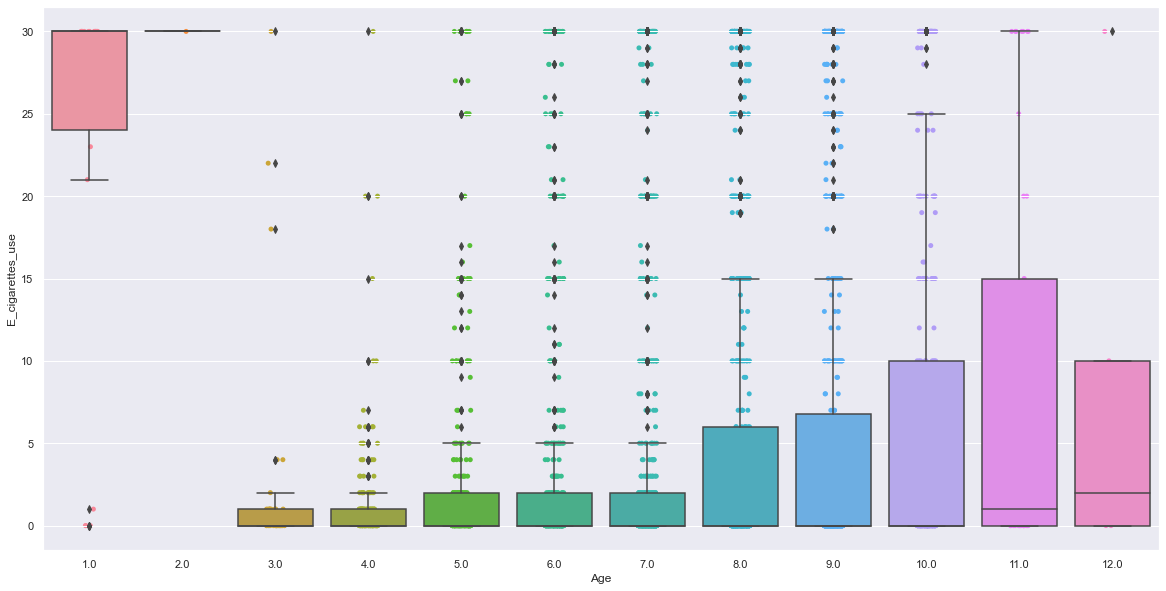

In [54]:
#g=sns.catplot(x="Age", y="E_cigarettes_use", data=nyts, kind="box", height=8.27, aspect=18.7/8.27)
#g.map(sns.stripplot, 'Age', 'E_cigarettes_use', order=sorted(nyts.Age.unique()))
sns.set(rc={'figure.figsize':(20,10)})
g=sns.boxplot(x="Age", y="E_cigarettes_use", data=nyts)
g=sns.stripplot(x="Age", y="E_cigarettes_use", data=nyts, zorder=.5)
#g.legend(title='Age', loc = 2, bbox_to_anchor = (1,1),labels=['9 yrs', '10 yrs', '11 yrs', '12 yrs', '13 yrs', '14 yrs', '15 yrs', '16 yrs', '17 yrs', '18 yrs', '19 yrs and +'])



In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
sns.set(color_codes=True)

In [57]:
sns.set(style="darkgrid")

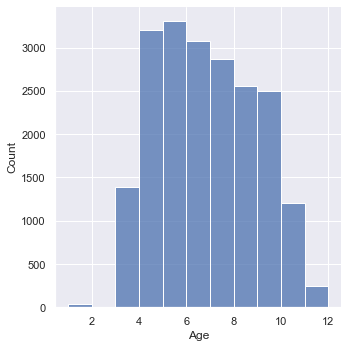

In [58]:
sns.displot(nyts['Age'], kind='hist', bins=11, rug=False)

In [59]:
nyts.Age.value_counts()

5.0     3308
4.0     3204
6.0     3079
7.0     2872
8.0     2562
9.0     2504
3.0     1391
10.0    1208
11.0     178
12.0      69
1.0       34
2.0        4
Name: Age, dtype: int64

# Stats of Gender

In [60]:
nyts.Gender.value_counts()

1.0    10368
2.0     9919
Name: Gender, dtype: int64

In [61]:
nyts.Gender.isna().sum()

126

In [62]:
conditions_Gender = [(nyts['Gender'] == 1), 
                   (nyts['Gender'] == 2)]
outputs_Gender = ['1','2']
nyts['gender'] = np.select(conditions_Gender, outputs_Gender, '3')
nyts.head(20)


,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,American Indian or Alaska Native,Asian,...,Other site,psu,stratum,hsms,finwgt,v_stratum,Race,E_cigarettes_use_category,Age_continuous,gender
0,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,NaN,16452,BR3,MS,262.047226,103,White,2,11.0,2
1,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,NaN,16452,BR3,MS,345.984971,103,Multi-racial,2,12.0,1
2,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,NaN,16452,BR3,MS,262.047226,103,White,2,12.0,2
3,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,16452,BR3,MS,369.050636,103,White,2,12.0,2
4,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,NaN,16452,BR3,MS,262.047226,103,White,2,11.0,2
5,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,NaN,16452,BR3,MS,345.984971,103,Asian,2,12.0,1
6,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,NaN,16452,BR3,MS,262.047226,103,White,2,11.0,2
7,3.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,16452,BR3,MS,254.413054,103,Black or African American,2,11.0,2
8,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,16452,BR3,MS,369.050636,103,White,2,12.0,2
9,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,NaN,16452,BR3,MS,262.047226,103,White,2,12.0,2


In [63]:
pd.crosstab(nyts.Gender, nyts.E_cigarettes_use_category, margins=True)

E_cigarettes_use_category,0,1,2,All
Gender,,,,
1.0,1031,684,8653,10368
2.0,1111,746,8062,9919
All,2142,1430,16715,20287


In [64]:
pd.crosstab(nyts.Gender, nyts.Ever_e_cigarettes_use, margins=True)

Ever_e_cigarettes_use,0.0,1.0,2.0,All
Gender,,,,
1.0,8519,1755,94,10368
2.0,7956,1891,72,9919
All,16475,3646,166,20287


# Stats of Race

In [65]:
nyts.Race.value_counts()

White                                        11530
Black or African American                     3932
Multi-racial                                  1495
Missing                                       1461
Asian                                          959
American Indian or Alaska Native               765
Native Hawaiian or Other Pacific Islander      271
Name: Race, dtype: int64

In [66]:
nyts.Race.isna().sum()

0

RacecountByE_cigarettes_use_category = nyts.groupby('Race')[['E_cigarettes_use_category']].count()
RacecountByE_cigarettes_use_category

pd.crosstab(nyts.Race, nyts.E_cigarettes_use_category, margins=True)

sns.set(rc={'figure.figsize':(20,10)})
g=sns.boxplot(x="Race", y="E_cigarettes_use", data=nyts)
g=sns.stripplot(x="Race", y="E_cigarettes_use", data=nyts)

sns.displot(nyts['Race'], kind='hist', bins=10, rug=False, height=8.27, aspect=18.7/8.27)

# Stats of Multiple Race

Note: This variable is named race_s in the public use data set. The multiple race categories are Hispanic, non-Hispanic (NH) White, non-Hispanic Black, non-Hispanic Asian, non-Hispanic American Indian or Alaskan Native (AIAN), and non-Hispanic Native Hawaiian or Pacific 
Islander (NHOPI).

In [67]:
conditions_race = [(nyts['Yes_Mexican'] == 1) | (nyts['Yes_Puerto'] == 1) | (nyts['Yes_Cuban'] == 1) | (nyts['Yes_Another'] == 1), 
                   (nyts['Not_Hispanic'] == 1)& (nyts['Race'] == 'White'), 
                   (nyts['Not_Hispanic'] == 1)& (nyts['Race'] == 'Asian'), 
                   (nyts['Not_Hispanic'] == 1)& (nyts['Race'] == 'American Indian or Alaska Native'), 
                   (nyts['Not_Hispanic'] == 1)& (nyts['Race'] == 'Black or African American'), 
                   (nyts['Not_Hispanic'] == 1)& (nyts['Race'] == 'Multi-racial')]
outputs_race = ['Hispanic','Non-Hispanic White', 'Non-Hispanic Asian', 'Non-Hispanic American Indian', 'Non-Hispanic Black', 'Non-Hispanic Multi-racial']
nyts['Multiple_Race'] = np.select(conditions_race, outputs_race, 'Missing')
nyts.head(20)

,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,American Indian or Alaska Native,Asian,...,psu,stratum,hsms,finwgt,v_stratum,Race,E_cigarettes_use_category,Age_continuous,gender,Multiple_Race
0,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,16452,BR3,MS,262.047226,103,White,2,11.0,2,Hispanic
1,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,16452,BR3,MS,345.984971,103,Multi-racial,2,12.0,1,Non-Hispanic Multi-racial
2,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,16452,BR3,MS,262.047226,103,White,2,12.0,2,Hispanic
3,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,16452,BR3,MS,369.050636,103,White,2,12.0,2,Non-Hispanic White
4,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,16452,BR3,MS,262.047226,103,White,2,11.0,2,Hispanic
5,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,16452,BR3,MS,345.984971,103,Asian,2,12.0,1,Non-Hispanic Asian
6,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,16452,BR3,MS,262.047226,103,White,2,11.0,2,Hispanic
7,3.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,16452,BR3,MS,254.413054,103,Black or African American,2,11.0,2,Non-Hispanic Black
8,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,16452,BR3,MS,369.050636,103,White,2,12.0,2,Non-Hispanic White
9,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,16452,BR3,MS,262.047226,103,White,2,12.0,2,Hispanic


In [68]:
nyts.Multiple_Race.value_counts()

Non-Hispanic White              9232
Hispanic                        5056
Non-Hispanic Black              3280
Non-Hispanic Multi-racial       1078
Non-Hispanic Asian               851
Missing                          693
Non-Hispanic American Indian     223
Name: Multiple_Race, dtype: int64

For poststratification purposes, a unique race and ethnicity was assigned to respondents with 
missing data on race and ethnicity, those with an “Other” classification, and those reporting 
multiple races. 

In [69]:
conditions_race = [(nyts['Multiple_Race'] == 'Non-Hispanic Multi-racial')|(nyts['Multiple_Race'] == 'Missing'), 
                   (nyts['Multiple_Race'] == 'Hispanic'), 
                   (nyts['Multiple_Race'] == 'Non-Hispanic Black'), 
                   (nyts['Multiple_Race'] == 'Non-Hispanic White') | (nyts['Multiple_Race'] == 'Non-Hispanic Asian') | (nyts['Multiple_Race'] == 'Non-Hispanic American Indian')]
outputs_race = ['4','2', '3', '1']
nyts['Race_Ethnicity'] = np.select(conditions_race, outputs_race, 'Missing')
nyts.head(20)

,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,American Indian or Alaska Native,Asian,...,stratum,hsms,finwgt,v_stratum,Race,E_cigarettes_use_category,Age_continuous,gender,Multiple_Race,Race_Ethnicity
0,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,BR3,MS,262.047226,103,White,2,11.0,2,Hispanic,2
1,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,BR3,MS,345.984971,103,Multi-racial,2,12.0,1,Non-Hispanic Multi-racial,4
2,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,BR3,MS,262.047226,103,White,2,12.0,2,Hispanic,2
3,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,BR3,MS,369.050636,103,White,2,12.0,2,Non-Hispanic White,1
4,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,BR3,MS,262.047226,103,White,2,11.0,2,Hispanic,2
5,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,BR3,MS,345.984971,103,Asian,2,12.0,1,Non-Hispanic Asian,1
6,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,BR3,MS,262.047226,103,White,2,11.0,2,Hispanic,2
7,3.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,BR3,MS,254.413054,103,Black or African American,2,11.0,2,Non-Hispanic Black,3
8,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,BR3,MS,369.050636,103,White,2,12.0,2,Non-Hispanic White,1
9,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,BR3,MS,262.047226,103,White,2,12.0,2,Hispanic,2


In [70]:
nyts.Race_Ethnicity.value_counts()

1    10306
2     5056
3     3280
4     1771
Name: Race_Ethnicity, dtype: int64

In [71]:
pd.crosstab(nyts.Race_Ethnicity, nyts.E_cigarettes_use_category, margins=True)

E_cigarettes_use_category,0,1,2,All
Race_Ethnicity,,,,
1,1155,870,8281,10306
2,568,310,4178,5056
3,251,118,2911,3280
4,180,138,1453,1771
All,2154,1436,16823,20413


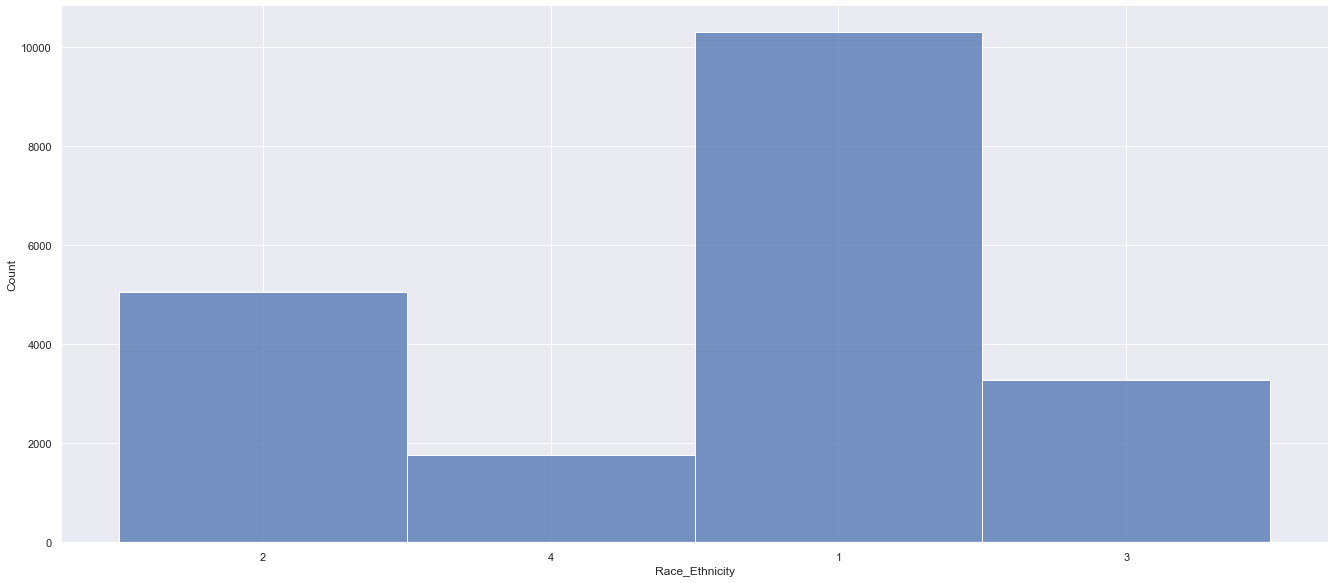

In [72]:
sns.displot(nyts['Race_Ethnicity'], kind='hist', bins=10, rug=False, height=8.27, aspect=18.7/8.27)

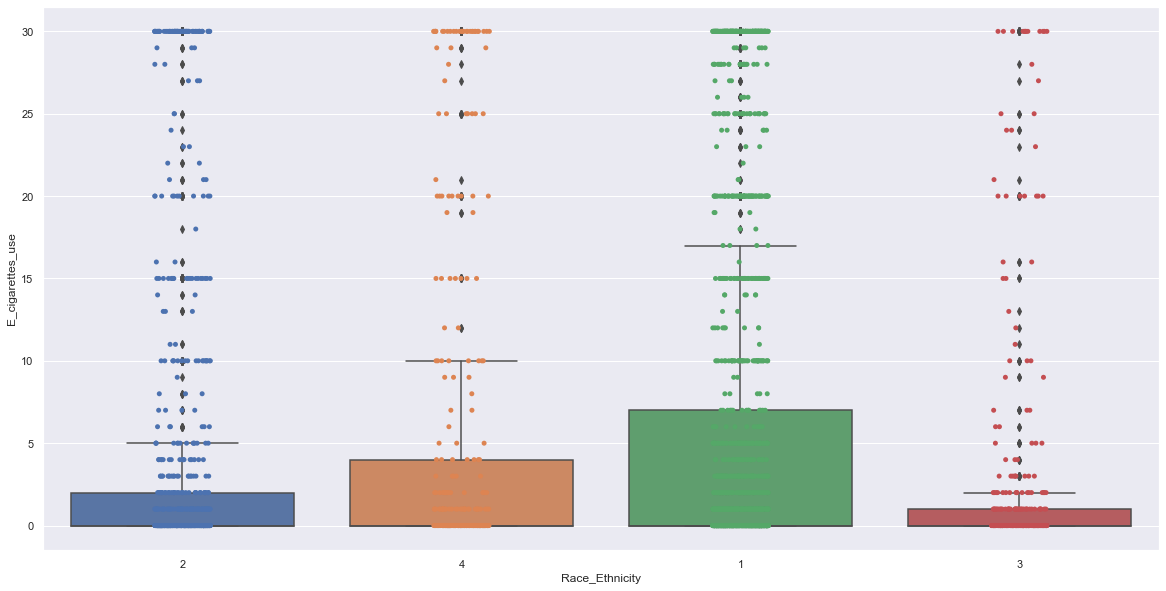

In [73]:
sns.set(rc={'figure.figsize':(20,10)})
g=sns.boxplot(x="Race_Ethnicity", y="E_cigarettes_use", data=nyts)
g=sns.stripplot(x="Race_Ethnicity", y="E_cigarettes_use", data=nyts)

# Stats of Education

In [74]:
conditions_Grade = [(nyts['Internet'] >= 4)&(nyts['Internet'] < 8), (nyts['Internet'] < 4)&(nyts['Internet'] > 0)]
outputs_Grade = ['2', '1']
nyts['Grade_category'] = np.select(conditions_Grade, outputs_Grade, '3')

In [75]:
nyts.Grade.describe()

count    20326.000000
mean         3.757158
std          1.975811
min          1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          8.000000
Name: Grade, dtype: float64

In [76]:
nyts.Grade.isna().sum()

87

In [77]:
nyts.Grade_category.isna().sum()

0

In [78]:
nyts.Grade_category.value_counts()

1    12155
2     6591
3     1667
Name: Grade_category, dtype: int64

In [79]:
pd.crosstab(nyts.Grade_category, nyts.E_cigarettes_use_category, margins=True)

E_cigarettes_use_category,0,1,2,All
Grade_category,,,,
1,1190,746,10219,12155
2,835,489,5267,6591
3,129,201,1337,1667
All,2154,1436,16823,20413


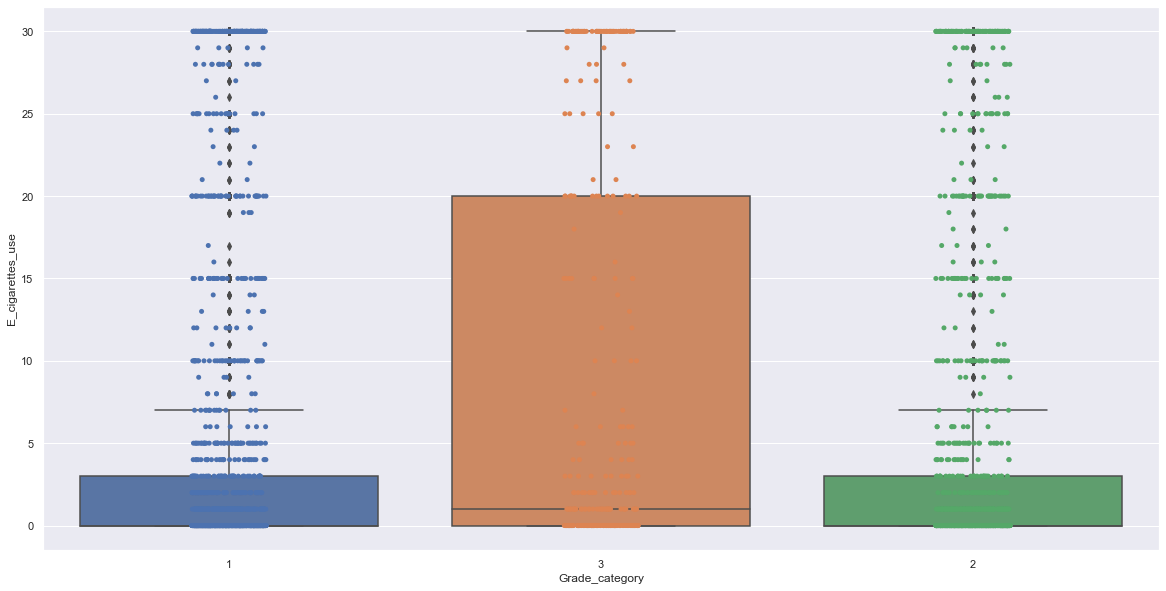

In [80]:
g=sns.boxplot(x="Grade_category", y="E_cigarettes_use", data=nyts)
g=sns.stripplot(x="Grade_category", y="E_cigarettes_use", data=nyts)

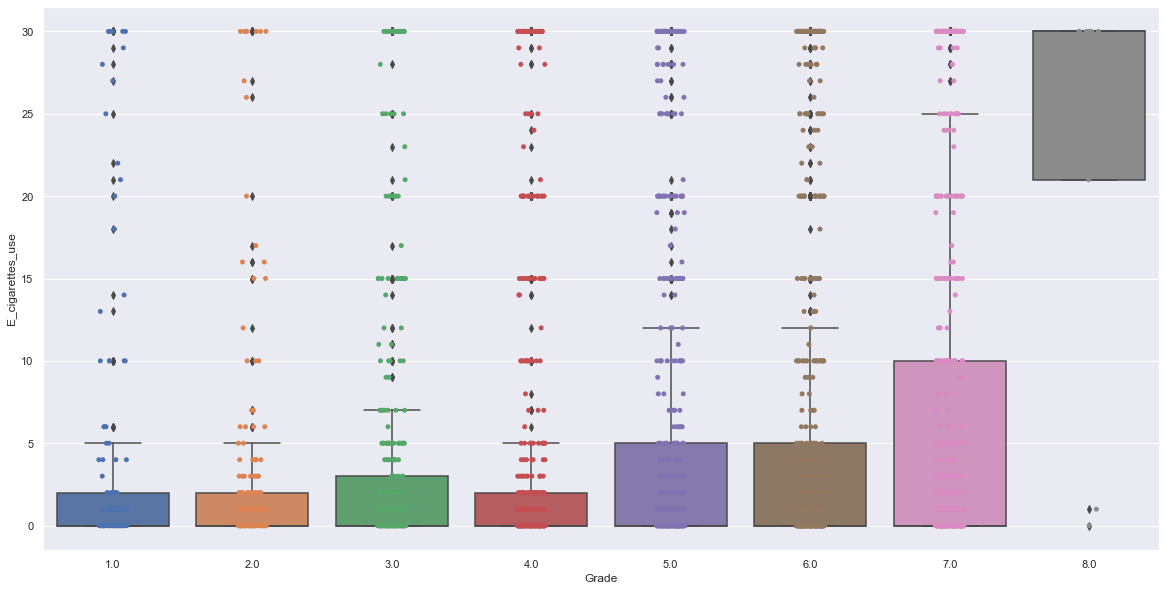

In [81]:
g=sns.boxplot(x="Grade", y="E_cigarettes_use", data=nyts)
g=sns.stripplot(x="Grade", y="E_cigarettes_use", data=nyts)

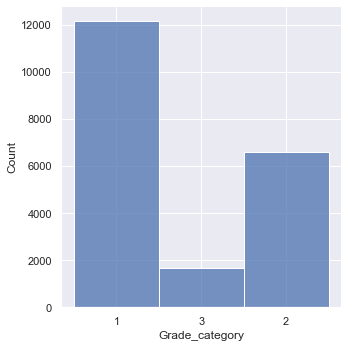

In [82]:
sns.displot(nyts['Grade_category'], kind='hist', bins=10, rug=False)

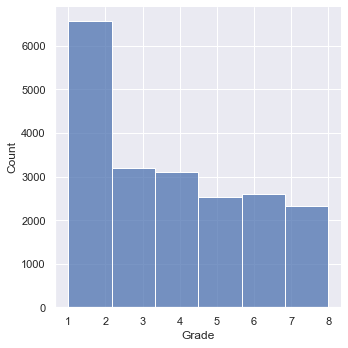

In [83]:
sns.displot(nyts['Grade'], kind='hist', bins=6, rug=False)

# Stats of Social Media

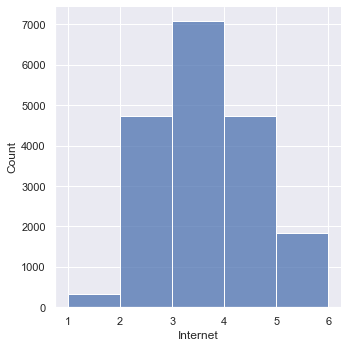

In [84]:
sns.displot(nyts['Internet'], kind='hist', bins=5, kde=False, rug=False)

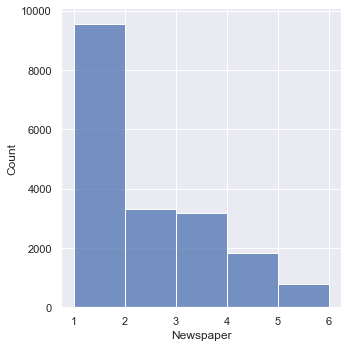

In [85]:
sns.displot(nyts['Newspaper'], kind='hist', bins=5, kde=False, rug=False)

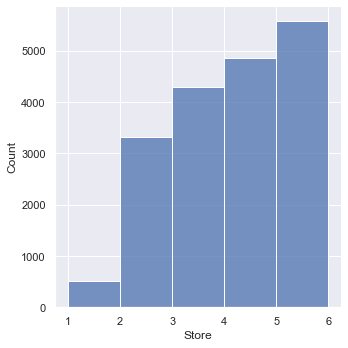

In [86]:
sns.displot(nyts['Store'], kind='hist', bins=5, kde=False, rug=False)

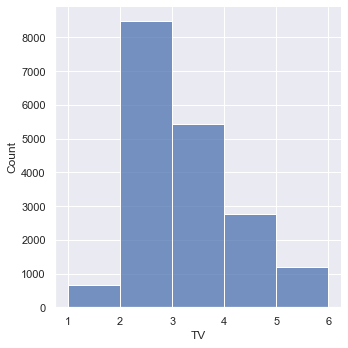

In [87]:
sns.displot(nyts['TV'], kind='hist', bins=5, kde=False, rug=False)

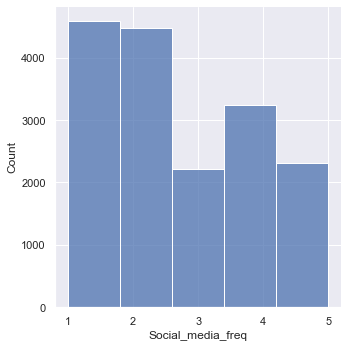

In [88]:
sns.displot(nyts['Social_media_freq'], kind='hist', bins=5, kde=False, rug=False)

In [89]:
conditions2 = [nyts['Internet'] >= 3, (nyts['Internet'] < 3)&(nyts['Internet'] > 0)]
outputs2 = ['Yes', 'No']
nyts['Internet_YN'] = np.select(conditions2, outputs2, 'Missing')

In [90]:
conditions3 = [nyts['Newspaper'] >= 3, (nyts['Newspaper'] < 3)&(nyts['Newspaper'] > 0)]
outputs3 = ['Yes', 'No']
nyts['Newspaper_YN'] = np.select(conditions3, outputs3, 'Missing')

In [91]:
conditions4 = [nyts['Store'] >= 3, (nyts['Store'] < 3)&(nyts['Store'] > 0)]
outputs4 = ['Yes', 'No']
nyts['Store_YN'] = np.select(conditions4, outputs4, 'Missing')


In [92]:
conditions5 = [nyts['TV'] >= 3, (nyts['TV'] < 3)&(nyts['TV'] > 0)]
outputs5 = ['Yes', 'No']
nyts['TV_YN'] = np.select(conditions5, outputs5, 'Missing')

In [93]:
nyts[['Internet_YN','Newspaper_YN', 'Store_YN', 'TV_YN']].apply(pd.Series.value_counts)

,Internet_YN,Newspaper_YN,Store_YN,TV_YN
Missing,1667,1769,1826,1859
No,5072,12874,3836,9153
Yes,13674,5770,14751,9401


# Social Media Use (time)

In [94]:
nyts.Social_media_use.isna().sum()

1787

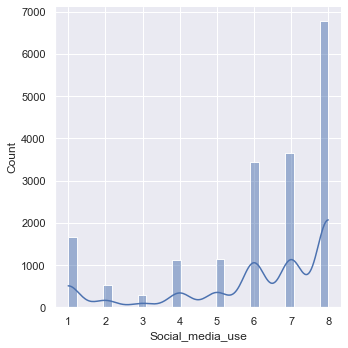

In [95]:
sns.displot(nyts['Social_media_use'], kind='hist', bins=30, kde=True, rug=False)

In [96]:
conditions7 = [nyts['Social_media_use'] >= 6, (nyts['Social_media_use'] < 4)&(nyts['Social_media_use'] > 1),(nyts['Social_media_use'] < 6)&(nyts['Social_media_use'] > 3)]
outputs7 = ['3', '1', '2']
nyts['Social_media_use_category'] = np.select(conditions7, outputs7, '4')

In [97]:
nyts.Social_media_use_category.value_counts()

3    13885
4     3453
2     2244
1      831
Name: Social_media_use_category, dtype: int64

# Social Media (exposure)

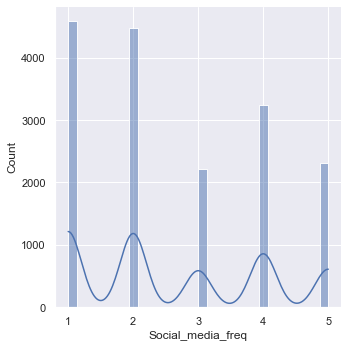

In [98]:
sns.displot(nyts['Social_media_freq'], kind='hist', bins=30, kde=True, rug=False)

In [99]:
conditions8 = [nyts['Social_media_freq'] >= 4, (nyts['Social_media_freq'] < 3)&(nyts['Social_media_freq'] > 0),nyts['Social_media_freq'] == 3]
outputs8 = ['3', '1', '2']
nyts['Social_media_category'] = np.select(conditions8, outputs8, '4')

In [100]:
nyts.Social_media_category.value_counts()

1    9055
3    5548
4    3594
2    2216
Name: Social_media_category, dtype: int64

# Social media Site


'QN135A': 'Facebook', 'QN135B':'Instgram', 'QN135C':'Snapchat','QN135D':'Tiktok', 'QN135E':'Twitter', 'QN135F':'Raddit', 'QN135G':'Youtube', 'QN135H':'Other site'

In [101]:
nyts['Facebook'].fillna(0, inplace=True)
nyts['Instgram'].fillna(0, inplace=True)
nyts['Snapchat'].fillna(0, inplace=True)
nyts['Tiktok'].fillna(0, inplace=True)
nyts['Twitter'].fillna(0, inplace=True)
nyts['Raddit'].fillna(0, inplace=True)
nyts['Youtube'].fillna(0, inplace=True)
nyts['Other site'].fillna(0, inplace=True)
conditions9 = [nyts['Facebook'] + nyts['Instgram']+ nyts['Snapchat']+ nyts['Tiktok'] + nyts['Twitter'] + nyts['Raddit']+ nyts['Youtube'] + nyts['Other site'] == 0,
              nyts['Facebook'] + nyts['Instgram']+ nyts['Snapchat']+ nyts['Tiktok'] + nyts['Twitter'] + nyts['Raddit']+ nyts['Youtube'] + nyts['Other site'] == 1,
              nyts['Facebook'] + nyts['Instgram']+ nyts['Snapchat']+ nyts['Tiktok'] + nyts['Twitter'] + nyts['Raddit']+ nyts['Youtube'] + nyts['Other site'] == 2,
              nyts['Facebook'] + nyts['Instgram']+ nyts['Snapchat']+ nyts['Tiktok'] + nyts['Twitter'] + nyts['Raddit']+ nyts['Youtube'] + nyts['Other site'] == 3,
              nyts['Facebook'] + nyts['Instgram']+ nyts['Snapchat']+ nyts['Tiktok'] + nyts['Twitter'] + nyts['Raddit']+ nyts['Youtube'] + nyts['Other site'] == 4,
              nyts['Facebook'] + nyts['Instgram']+ nyts['Snapchat']+ nyts['Tiktok'] + nyts['Twitter'] + nyts['Raddit']+ nyts['Youtube'] + nyts['Other site'] == 5,
              nyts['Facebook'] + nyts['Instgram']+ nyts['Snapchat']+ nyts['Tiktok'] + nyts['Twitter'] + nyts['Raddit']+ nyts['Youtube'] + nyts['Other site'] == 6,
              nyts['Facebook'] + nyts['Instgram']+ nyts['Snapchat']+ nyts['Tiktok'] + nyts['Twitter'] + nyts['Raddit']+ nyts['Youtube'] + nyts['Other site'] == 7,
              nyts['Facebook'] + nyts['Instgram']+ nyts['Snapchat']+ nyts['Tiktok'] + nyts['Twitter'] + nyts['Raddit']+ nyts['Youtube'] + nyts['Other site'] == 8,
             ]
outputs9 = ['0','1', '2', '3', '4', '5', '6', '7','8']
nyts['Social_media_sites'] = np.select(conditions9, outputs9, '9')
nyts.head(20)

,Age,Gender,Grade,Not_Hispanic,Yes_Mexican,Yes_Puerto,Yes_Cuban,Yes_Another,American Indian or Alaska Native,Asian,...,Multiple_Race,Race_Ethnicity,Grade_category,Internet_YN,Newspaper_YN,Store_YN,TV_YN,Social_media_use_category,Social_media_category,Social_media_sites
0,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,Hispanic,2,1,Yes,Yes,Yes,Yes,1,1,0
1,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,Non-Hispanic Multi-racial,4,1,Yes,No,Yes,Yes,3,3,5
2,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,Hispanic,2,1,No,No,No,No,4,4,0
3,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,Non-Hispanic White,1,1,Yes,No,Yes,Yes,2,1,2
4,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,Hispanic,2,3,Missing,Missing,Missing,Missing,4,4,0
5,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,...,Non-Hispanic Asian,1,1,No,No,Yes,Yes,2,1,1
6,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,...,Hispanic,2,2,Yes,No,Yes,Yes,2,1,4
7,3.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,Non-Hispanic Black,3,1,No,No,Yes,No,3,1,4
8,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,Non-Hispanic White,1,1,No,No,Yes,Yes,3,1,0
9,4.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,Hispanic,2,2,Yes,No,No,No,3,1,0


In [102]:
nyts.Social_media_sites = pd.to_numeric(nyts.Social_media_sites)

In [103]:
nyts.Social_media_sites.describe()

count    20413.000000
mean         1.704159
std          1.899963
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max          8.000000
Name: Social_media_sites, dtype: float64

In [104]:
nyts.Social_media_sites.value_counts()

0    8533
1    2825
3    2578
2    2460
4    2078
5    1085
6     493
7     275
8      86
Name: Social_media_sites, dtype: int64

In [106]:
nyts.to_csv('nyts.csv',index=False)